<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/mec647_VI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**init cells**

In [1]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

In [4]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade pyyaml
try:
    import google.colab
except ImportError:
    pass
else:
    pass
    # google.colab.output.enable_custom_widget_manager();
try:
    import pyvista
except ImportError:
    !pip3 install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401

# The solution to a bound constrained, nonlinear, singularly perturbed, variational problem

Let $\Omega = (0, L)\times (0, H)$ and consider the energy $E_\ell(u)$ defined as
$$
E_\ell(u)=\int_\Omega \left(\ell|\nabla u|^2 + \frac{u}{\ell} \right)dx$$
we solve:
$$min \left\{ E_\ell(u): {0\leq u(x)\leq 1}\right\}$$ for $ u\in H^1(\Omega, R)$ with $u(0, \cdot)=1, u(L, \cdot)=0$ as boundary conditions. 

We solve this problem varying $\ell$.

The energy above is the sum of a (positive) gradient energy density term and a (positive only in the domain of admissibility for $u$).
The first penalises the spatial variations, the latter pays for the pointwise value of the field. 

Boundary conditions are such that a competition between these two terms is necessary.

The interest of the toy-model above, is that will be interpreted as *the surface energy* (that is, the fracture energy) in a problem of crack propagation. There, the scalar variable $u$ is interpreted as a *damage density*. 

In [5]:
try:
  !git clone https://github.com/kumiori/mec647.git
except:
  pass

fatal: destination path 'mec647' already exists and is not an empty directory.


In [6]:
sys.path.append('mec647/')

In [7]:
import numpy as np

import dolfinx
import dolfinx.plot
import dolfinx.io
from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)

import pyvista
from pyvista.utilities import xvfb

import dolfinx.plot

import dolfinx.mesh
from dolfinx.mesh import CellType
import ufl

from mpi4py import MPI
import petsc4py
from petsc4py import PETSc
import sys
import yaml

sys.path.append("../")
from solvers import SNESSolver

petsc4py.init(sys.argv)

import logging

logging.basicConfig(level=logging.INFO)


### Parameters and dirtree

For reference, we store all relevant parameters, necessary for a computation, into an external file, here ```parameters.yml```, read into the ```parameters``` dictionary.


In [18]:

with open("mec647/test/parameters.yml") as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)

from pathlib import Path
outdir = "temp/out"
Path(outdir).mkdir(parents=True, exist_ok=True)

Lx = parameters.get("geometry").get("Lx")
Ly = parameters.get("geometry").get("Ly")
ell = parameters.get("model").get("ell")



In [10]:
mesh = dolfinx.mesh.create_rectangle(MPI.COMM_WORLD, [[0.0, 0.0], [Lx, Ly]],
                                     [100, 10],
                                     cell_type=CellType.triangle)

In [14]:
V = FunctionSpace(mesh, ("CG", 1))


u = Function(V)
energy = (ell * ufl.inner(ufl.grad(u), ufl.grad(u)) + u / ell) * ufl.dx
denergy = ufl.derivative(energy, u, ufl.TestFunction(V))
ddenergy = ufl.derivative(denergy, u, ufl.TrialFunction(V))



## Boundary conditions

Are functions defined in the entire space, whose restriction to the  boundary or a boundary part, constitutes an external datum.

For parallel execution, ```localForm()``` allows to correctly set vector values, locally.



In [15]:

zero = Function(V)
with zero.vector.localForm() as loc:
    loc.set(0.0)

one = Function(V)
with one.vector.localForm() as loc:
    loc.set(1.0)


### Boundary parts

Boundary entities, that is facets  of dimension $n-1$, are identified geometrically by ```locate_entities_boundary```. 
Its last argument is a function of the (discrete) point $x$ (here, ```left(x)``` and ```right(x)```) returning whether or not (```True/False```) the point belongs to the boundary.

In [16]:


def left(x):
    is_close = np.isclose(x[0], 0.0)
    return is_close


def right(x):
    is_close = np.isclose(x[0], Lx)
    return is_close


left_facets = dolfinx.mesh.locate_entities_boundary(mesh,
                                                    mesh.topology.dim - 1,
                                                    left)
left_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim - 1,
                                                left_facets)

right_facets = dolfinx.mesh.locate_entities_boundary(mesh,
                                                     mesh.topology.dim - 1,
                                                     left)
right_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim - 1,
                                                 right_facets)

bcs = [dirichletbc(zero, left_dofs), dirichletbc(one, right_dofs)]


## The problem, the solver.

The problem class ```SNESSolver``` gives access to (a range of) 
[Scalable Nonlinear Equations Solvers](https://petsc4py.readthedocs.io/en/stable/manual/snes/) setting up the necessary residual function (the energy gradient), a pointer to boundary conditions, and the interval bounds.


Internally, ```SNESSolver``` computes the Jacobian of the energy function by automatic differentiation. Check ```mec647/solvers/__init__.py``` for the details.

In [17]:
problem = SNESSolver(
    denergy,
    u,
    bcs,
    bounds=(zero, one),
    petsc_options=parameters.get("solvers").get("damage").get("snes"),
    prefix="vi",
)


### Solver setup
Fine tuning the solver to the type of mathematical problem at hand:
a **bound constrained, nonlinear, singularly perturbed variational problem**.

In [19]:
solver_snes = problem.solver
solver_snes.setType("vinewtonrsls")

solver_snes.setTolerances(rtol=1.0e-8, max_it=250)
solver_snes.getKSP().setType("preonly")
solver_snes.getKSP().setTolerances(rtol=1.0e-8)
solver_snes.getKSP().getPC().setType("lu")


def monitor(snes, its, fgnorm):
    print(f"Iteration {its:d}, error: {fgnorm:2.3e}")


solver_snes.setMonitor(monitor)
solver_snes.solve(None, u.vector)


  0 SNES Function norm 3.372863694252e+00 
Iteration 0, error: 3.373e+00
  1 SNES Function norm 3.035973896462e-01 
Iteration 1, error: 3.036e-01
  2 SNES Function norm 1.993160527627e-01 
Iteration 2, error: 1.993e-01
  3 SNES Function norm 1.464048325705e-01 
Iteration 3, error: 1.464e-01
  4 SNES Function norm 1.140416590549e-01 
Iteration 4, error: 1.140e-01
  5 SNES Function norm 9.195250887762e-02 
Iteration 5, error: 9.195e-02
  6 SNES Function norm 7.573422917933e-02 
Iteration 6, error: 7.573e-02
  7 SNES Function norm 6.318524353043e-02 
Iteration 7, error: 6.319e-02
  8 SNES Function norm 5.308245391446e-02 
Iteration 8, error: 5.308e-02
  9 SNES Function norm 4.469200152153e-02 
Iteration 9, error: 4.469e-02
 10 SNES Function norm 3.754688529081e-02 
Iteration 10, error: 3.755e-02
 11 SNES Function norm 3.133577118176e-02 
Iteration 11, error: 3.134e-02
 12 SNES Function norm 2.584312024322e-02 
Iteration 12, error: 2.584e-02
 13 SNES Function norm 2.091497608150e-02 
Itera

## Postprocessing


1.   Output data
2.   Visualise
3.   Quant processing



In [21]:

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, f"{outdir}/u.xdmf", "w") as f:
    f.write_mesh(mesh)
    f.write_function(u)

In 
```test_viz/``` some helper functions allow to retrieve a plot object for scalar, vectors, and restrictions to curves of fields.

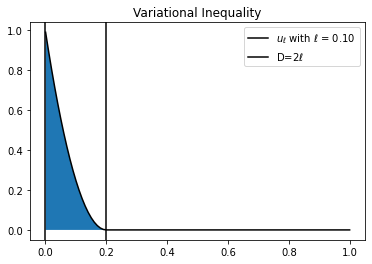

In [24]:

sys.path.append("mec647/test")
from test_viz import plot_vector, plot_scalar, plot_profile

xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True

plotter = pyvista.Plotter(
    title="Test VI",
    window_size=[800, 600],
    shape=(1, 1),
)
_props = {"show_edges":True, "show_scalar_bar": True, "clim":[0, 1]}
_plt = plot_scalar(u, plotter, subplot=(0, 0), lineproperties=_props)

# _plt = plot_vector(u, plotter, subplot=(0, 1))

_plt.screenshot(f"{outdir}/test_vi_MPI{MPI.COMM_WORLD.size}.png")

if not pyvista.OFF_SCREEN:
    plotter.show()

tol = 1e-3
xs = np.linspace(0 + tol, Lx - tol, 101)
points = np.zeros((3, 101))
points[0] = xs

_plt, data = plot_profile(
    u,
    points,
    plotter,
    subplot=(0, 0),
    lineproperties={
        "c": "k",
        "label": f"$u_\ell$ with $\ell$ = {ell:.2f}"
    },
)
ax = _plt.gca()
ax.axvline(0.0, c="k")
ax.axvline(2 * ell, c="k", label='D=$2\ell$')
_plt.legend()
_plt.fill_between(data[0], data[1].reshape(len(data[1])))
_plt.title("Variational Inequality")
_plt.savefig(f"{outdir}/test_vi_profile_MPI{MPI.COMM_WORLD.size}-{ell:.3f}.png")


Compute macroscopic quantities 

In [26]:
from dolfinx.fem.assemble import assemble_scalar

min_en = assemble_scalar(dolfinx.fem.form(energy))

data = {"ell": {},
        "minen": {}}


In [33]:
# for _ell in np.range(??, ??):
#   # solution for given ell
#   # energy of solution 
#   data["ell"].append(_ell)
#   data["minen"].append(_minen)

{}